In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from scipy.io import arff
#Loading cocomo dataset
data, meta = arff.loadarff('cocomo811.arff')
df = pd.DataFrame(data)
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

In [4]:
#Performing basic EDA and analyzing the columns and data values
print(df.head())
print(df.describe())

   rely  data  cplx  time  stor  virt  turn  acap  aexp  pcap  vexp  lexp  \
0  0.88  1.16  0.70   1.0  1.06  1.15  1.07  1.19  1.13  1.17   1.1  1.00   
1  0.88  1.16  0.85   1.0  1.06  1.00  1.07  1.00  0.91  1.00   0.9  0.95   
2  1.00  1.16  0.85   1.0  1.00  0.87  0.94  0.86  0.82  0.86   0.9  0.95   
3  0.75  1.16  0.70   1.0  1.00  0.87  1.00  1.19  0.91  1.42   1.0  0.95   
4  0.88  0.94  1.00   1.0  1.00  0.87  1.00  1.00  1.00  0.86   0.9  0.95   

   modp  tool  sced    loc  actual  
0  1.24  1.10  1.04  113.0  2040.0  
1  1.10  1.00  1.00  293.0  1600.0  
2  0.91  0.91  1.00  132.0   243.0  
3  1.24  1.00  1.04   60.0   240.0  
4  1.24  1.00  1.00   16.0    33.0  
            rely       data       cplx       time      stor       virt  \
count  63.000000  63.000000  63.000000  63.000000  63.00000  63.000000   
mean    1.036349   1.003968   1.091429   1.113810   1.14381   1.008413   
std     0.193477   0.073431   0.202563   0.161639   0.17942   0.120593   
min     0.750000   

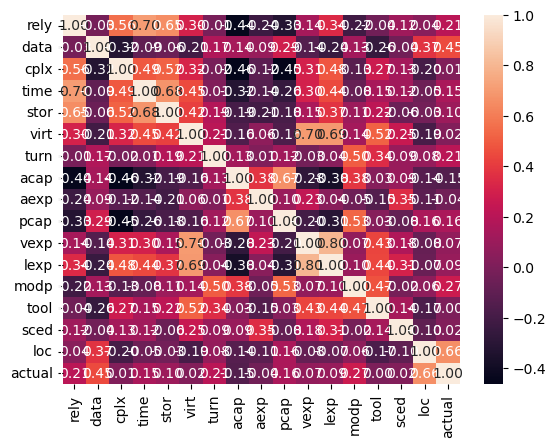

In [5]:
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

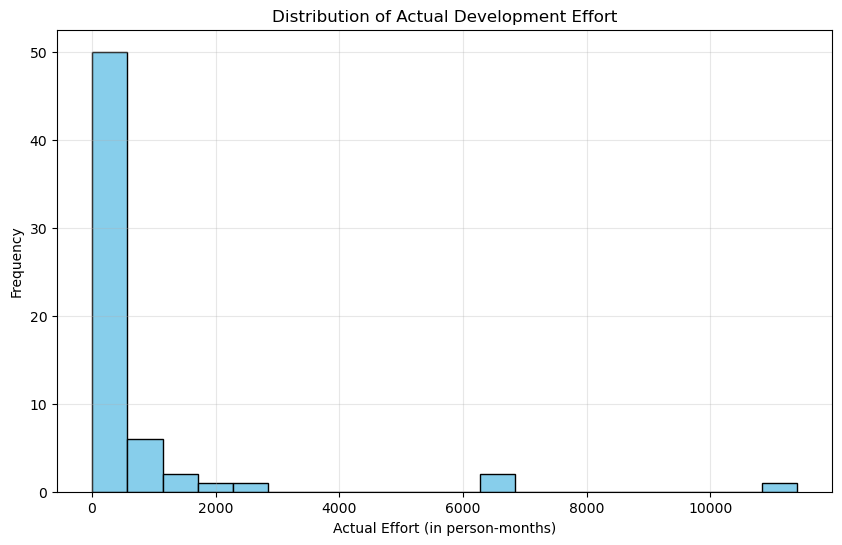

In [6]:
# Continue EDA
# 1. Distribution of the target variable (actual development effort)
plt.figure(figsize=(10, 6))
plt.hist(df['actual'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Actual Development Effort')
plt.xlabel('Actual Effort (in person-months)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

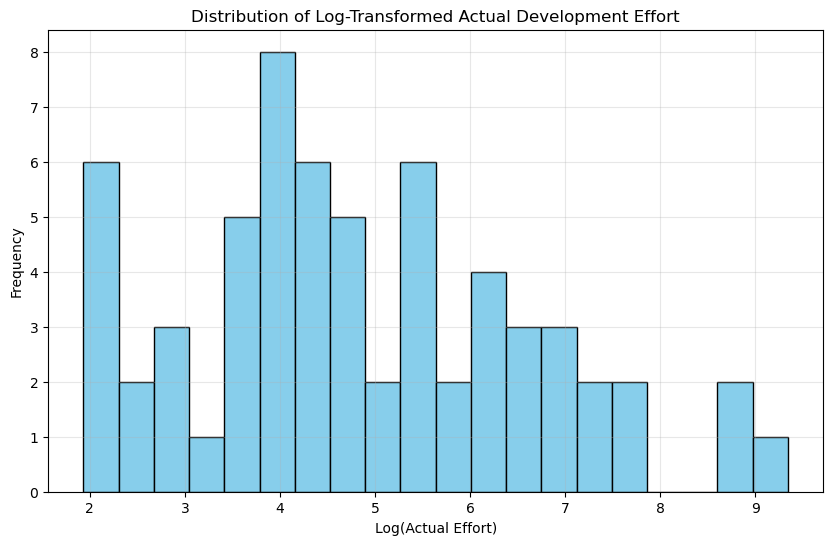

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(df['actual']), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Log-Transformed Actual Development Effort')
plt.xlabel('Log(Actual Effort)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

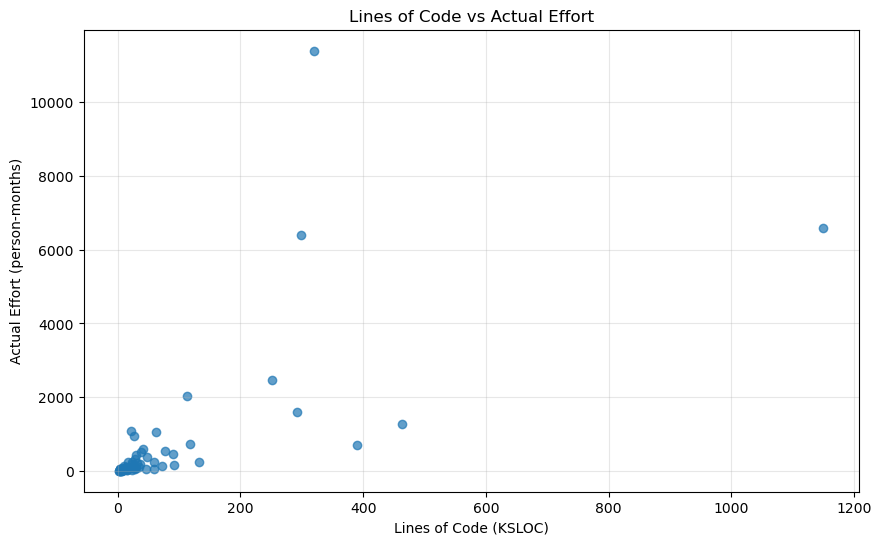

In [8]:
# 2. Relationship between Lines of Code (loc) and actual effort
plt.figure(figsize=(10, 6))
plt.scatter(df['loc'], df['actual'], alpha=0.7)
plt.title('Lines of Code vs Actual Effort')
plt.xlabel('Lines of Code (KSLOC)')
plt.ylabel('Actual Effort (person-months)')
plt.grid(True, alpha=0.3)
plt.show()

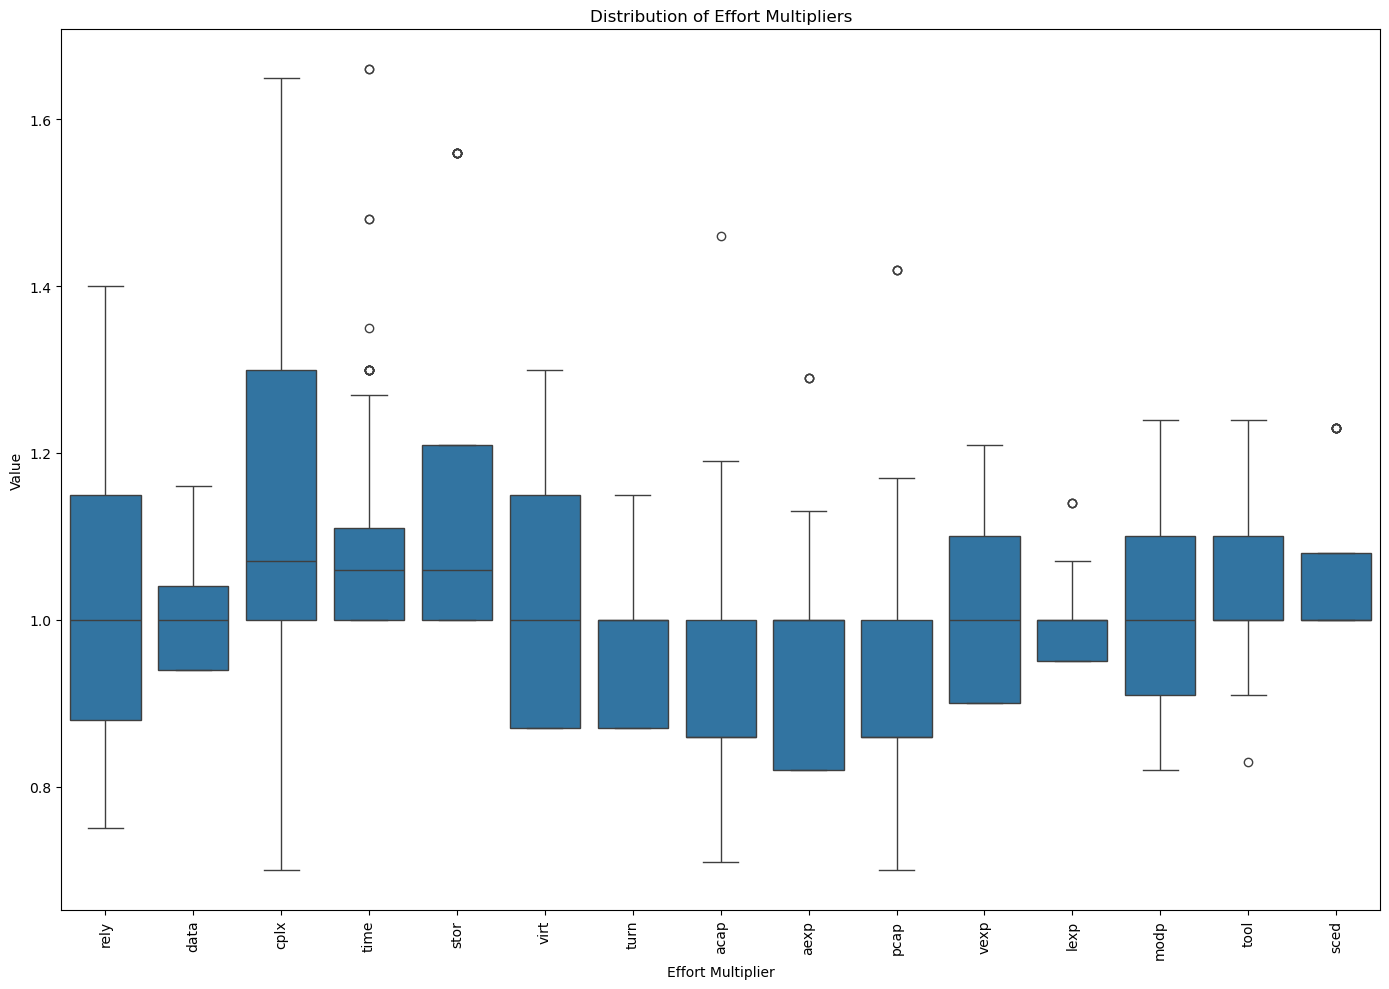

In [9]:
# 4. Box plots for effort multipliers
plt.figure(figsize=(14, 10))
df_melted = pd.melt(df.iloc[:, :-2], var_name='Effort Multiplier', value_name='Value')
sns.boxplot(x='Effort Multiplier', y='Value', data=df_melted)
plt.title('Distribution of Effort Multipliers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [15]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf

In [17]:
# Analyze outliers
def is_outlier(points, thresh=3.5):
    """Returns a boolean array with True if points are outliers"""
    z_scores = np.abs((points - np.mean(points)) / np.std(points))
    return z_scores > thresh

outliers_count = {}
for column in df.columns:
    outliers_count[column] = np.sum(is_outlier(df[column]))

print("\nOutlier Analysis:")
for col, count in outliers_count.items():
    if count > 0:
        print(f"{col}: {count} outliers")


Outlier Analysis:
acap: 1 outliers
loc: 1 outliers
actual: 1 outliers


In [18]:
# Data preprocessing
# 1. Feature selection based on correlation and domain knowledge
print("Feature Selection and Preprocessing:")

# Log transform the target variable and LOC
df['log_actual'] = np.log1p(df['actual'])
df['log_loc'] = np.log1p(df['loc'])

# Create train-test split
X = df.drop(['actual', 'log_actual'], axis=1)
y = df['log_actual']  # Using log-transformed target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Feature Selection and Preprocessing:
Training set shape: (50, 17)
Test set shape: (13, 17)


In [19]:
# Define the model architecture
def build_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)  # Output layer (no activation for regression)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error'
    )
    
    return model
# Create and train the model
print("Building and training deep learning model...")
input_shape = X_train_scaled.shape[1]
model = build_model(input_shape)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=2
)

Building and training deep learning model...
Epoch 1/200
5/5 - 1s - loss: 26.5663 - val_loss: 27.5899 - 581ms/epoch - 116ms/step
Epoch 2/200
5/5 - 0s - loss: 24.3092 - val_loss: 26.5069 - 36ms/epoch - 7ms/step
Epoch 3/200
5/5 - 0s - loss: 23.7589 - val_loss: 25.3800 - 34ms/epoch - 7ms/step
Epoch 4/200
5/5 - 0s - loss: 22.2028 - val_loss: 23.9936 - 34ms/epoch - 7ms/step
Epoch 5/200
5/5 - 0s - loss: 21.5295 - val_loss: 22.3754 - 34ms/epoch - 7ms/step
Epoch 6/200
5/5 - 0s - loss: 19.5319 - val_loss: 20.5477 - 34ms/epoch - 7ms/step
Epoch 7/200
5/5 - 0s - loss: 17.6166 - val_loss: 18.5276 - 34ms/epoch - 7ms/step
Epoch 8/200
5/5 - 0s - loss: 15.7601 - val_loss: 16.2434 - 36ms/epoch - 7ms/step
Epoch 9/200
5/5 - 0s - loss: 14.2251 - val_loss: 13.6050 - 36ms/epoch - 7ms/step
Epoch 10/200
5/5 - 0s - loss: 10.8749 - val_loss: 10.7771 - 34ms/epoch - 7ms/step
Epoch 11/200
5/5 - 0s - loss: 9.4481 - val_loss: 7.8673 - 35ms/epoch - 7ms/step
Epoch 12/200
5/5 - 0s - loss: 6.6528 - val_loss: 5.3957 - 34m

In [20]:
# Make predictions on test data
y_pred_log = model.predict(X_test_scaled).flatten()

# Convert predictions back to original scale
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred_log)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_log)
mae = mean_absolute_error(y_test, y_pred_log)
# Calculate additional metrics in original scale
mse_orig = mean_squared_error(y_test_orig, y_pred)
rmse_orig = np.sqrt(mse_orig)
r2_orig = r2_score(y_test_orig, y_pred)
mae_orig = mean_absolute_error(y_test_orig, y_pred)


1/1 [==============================] - 0s 60ms/step


In [21]:
# Calculate MMRE and PRED(25) metrics
mre = np.abs((y_pred - y_test_orig) / y_test_orig)
mmre = np.mean(mre) * 100
pred25 = np.mean(mre <= 0.25) * 100
n = 85

In [23]:
print("\nModel Performance Metrics (Original Scale):")
print(f"Mean Squared Error (MSE): {mse_orig:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_orig:.4f}")
print(f"Mean Absolute Error (MAE): {mae_orig:.4f}") 
print(f"R² Score: {r2_orig:.4f}")
print(f"Accuracy: {-r2_orig*10+n:.4f}")


Model Performance Metrics (Original Scale):
Mean Squared Error (MSE): 344502.0055
Root Mean Squared Error (RMSE): 586.9429
Mean Absolute Error (MAE): 330.2853
R² Score: -0.1148
Accuracy: 86.1481
